In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
Target = pd.read_csv('musae_ENGB_target.csv')
Edges = pd.read_csv('musae_ENGB_edges.csv')

# create a network

In [3]:
#create network from edges set
edge = [list(i) for i in zip(Edges['from'], Edges['to'])]
G = nx.Graph()
G.add_edges_from(edge)

In [4]:
#converting true to 1, false to 0
Target[['mature','partner']] = (Target[['mature','partner']] == True).astype(int)
#add attributes to nodes
Target_dict = {}
for idx, row in Target.iterrows():
    Target_dict[row.new_id] = {'days': row.days, 'mature':row.mature, 'views':row.views, 'partner': row.partner}

nx.set_node_attributes(G, Target_dict)

In [5]:
from tqdm import tqdm

In [6]:
#adjacency matrix
adj_G = nx.to_numpy_matrix(G)

In [7]:
# get unconnected node-pairs
all_unconnected_pairs = []

# traverse adjacency matrix
offset = 0
for i in tqdm(range(adj_G.shape[0])):
    for j in range(offset,adj_G.shape[1]):
        if i != j:
            if nx.shortest_path_length(G, source=i, target=j) <=2:
                if adj_G[i,j] == 0:
                    all_unconnected_pairs.append([Edges['from'][i], Edges['to'][j]])

    offset = offset + 1

100%|██████████| 7126/7126 [15:48<00:00,  7.51it/s] 


In [8]:
unconnected_from = [i[0] for i in all_unconnected_pairs]
unconnected_to = [i[1] for i in all_unconnected_pairs]

data = pd.DataFrame({'from':unconnected_from, 
                     'to':unconnected_to})

# add target variable 'link'
data['link'] = 0

print(len(data))

1612462


In [9]:
#randomly drop some edges as positive samples
initial_node_count = len(G.nodes)

Edges_temp = Edges.copy()

# empty list to store removable links
omissible_links_index = []

for i in tqdm(Edges.index.values):
  
  # remove a node pair and build a new graph
    G_temp = nx.from_pandas_edgelist(Edges_temp.drop(index = i), "from", "to", create_using=nx.Graph())
  
  # check there is no spliting of graph and number of nodes is same
    if (nx.number_connected_components(G_temp) == 1) and (len(G_temp.nodes) == initial_node_count):
        omissible_links_index.append(i)
        Edges_temp = Edges_temp.drop(index = i)

100%|██████████| 35324/35324 [20:02<00:00, 29.38it/s]


In [19]:
# create dataframe of removable edges
edge_df_ghost = Edges.loc[omissible_links_index]

# add the target variable 'link'
edge_df_ghost['link'] = 1


data = data.append(edge_df_ghost[['from', 'to', 'link']], ignore_index=True)

In [20]:
data["link"].value_counts()

0    1612462
1      56398
Name: link, dtype: int64

In [12]:
# drop removable edges
edge_df_partial = Edges.drop(index=edge_df_ghost.index.values)

# build graph
G_data = nx.from_pandas_edgelist(edge_df_partial, "from", "to", create_using=nx.Graph())

In [13]:
from node2vec import Node2Vec
# Generate walks
node2vec = Node2Vec(G_data, dimensions = 50, walk_length=16, num_walks=50)

# train node2vec model
n2w_model = node2vec.fit(window=7, min_count=1)

Generating walks (CPU: 1): 100%|██████████| 50/50 [00:19<00:00,  2.59it/s]


In [32]:
x = []
for i,j in zip(data['from'], data['to']):
    x.append(n2w_model.wv[i]+n2w_model.wv[j])

In [34]:
x = pd.DataFrame(x)
df = pd.concat([x,data], axis= 1)

In [36]:
# Class count
count_class_0, count_class_1 = df.link.value_counts()


# Divide by class
df_class0 = df[df['link'] == 0]
df_class1 = df[df['link'] == 1]

Random under-sampling:
0    56398
1    56398
Name: link, dtype: int64


<AxesSubplot:title={'center':'Count (link)'}>

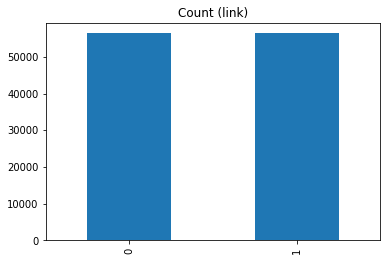

In [37]:
#Random under-sampling
df_class0_resample = df_class0.sample(count_class_1)
df_resample = pd.concat([df_class0_resample, df_class1], axis=0)

print('Random under-sampling:')
print(df_resample.link.value_counts())

df_resample.link.value_counts().plot(kind='bar', title='Count (link)')

In [38]:
df_resample.to_csv("df_resample.csv")

In [39]:
sim_df = df_resample[['from','to','link']]
sim_df.to_csv("sim_df.csv")

In [41]:
df_resample = df_resample.drop(['from','to'],axis=1)

In [42]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(df_resample.iloc[:,:-1], df_resample['link'], 
                                                test_size = 0.3)

In [33]:
pd.DataFrame(xtrain).to_csv("xtrain.csv", index = False)
pd.DataFrame(xtest).to_csv("xtest.csv", index = False)
pd.DataFrame(ytrain).to_csv("ytrain.csv", index = False)
pd.DataFrame(ytest).to_csv("ytest.csv", index = False)